# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from itertools import combinations

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

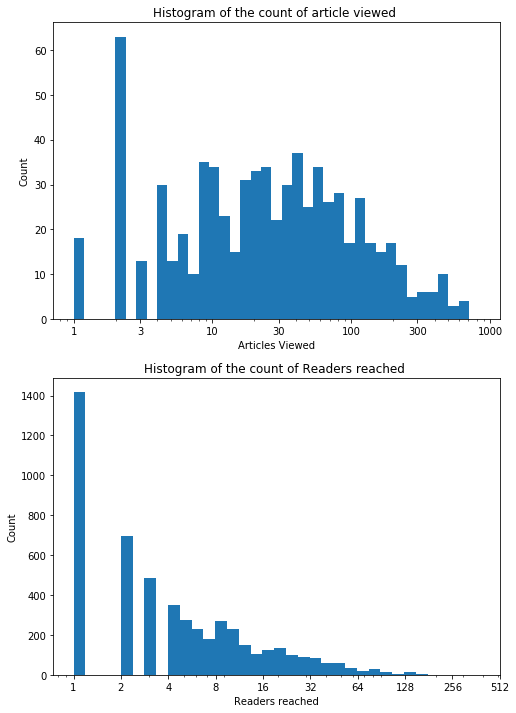

In [3]:
plt.figure(figsize = [8,12])

plt.subplot(2,1,1)
bins = 10**np.arange(0,3,0.075)
ticks = [1,3,10,30,100,300,1000]
labels = [1,3,10,30,100,300,1000]
plt.hist(data = df.groupby('article_id').count(), x ='title',bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Articles Viewed')
plt.ylabel('Count')
plt.title('Histogram of the count of article viewed ');

plt.subplot(2,1,2)
bins = 10**np.arange(0,2.6,0.075)
ticks = [1,2,4,8,16,32,64,128,256,512]
labels = [1,2,4,8,16,32,64,128,256,512]
plt.hist(data = df.groupby('email').count(), x ='title',bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Readers reached')
plt.ylabel('Count')
plt.title('Histogram of the count of Readers reached ');


In [4]:
df.groupby('article_id').count()['title'].describe()

count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: title, dtype: float64

In [5]:
df.groupby('email').count()['title'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
duplicated_id = df_content[df_content.article_id.duplicated()]['article_id'].values
df_content[df_content['article_id'].isin(duplicated_id)].sort_values(by = 'article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [8]:
# Remove any rows that have the same article_id - only keep the first
list_to_drop = [365,692,971,761,970]
df_content.drop(list_to_drop, inplace = True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# The number of unique articles that have an interaction with a user.
df.article_id.nunique()

714

In [10]:
# The number of unique articles in the dataset (whether they have any interactions or not).
df_content.article_id.nunique()

1051

In [11]:
# The number of unique users in the dataset. (excluding null values) 
df.email.nunique()

5148

In [12]:
# The number of user-article interactions in the dataset.
df.shape[0]

45993

In [13]:
unique_articles = 714  # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
df['article_id'].value_counts()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [15]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
df.groupby('title').count()['user_id'].sort_values(ascending = False).index[:2]

Index(['use deep learning for image classification', 'insights from new york car accident reports'], dtype='object', name='title')

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('title').count()['user_id'].sort_values(ascending = False).index[:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('article_id').count()['user_id'].sort_values(ascending = False).index[:n])
    top_articles = [str(i) for i in top_articles]
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''    
    
    user_item = pd.pivot_table(df, values='title', index=['user_id'],
                    columns=['article_id'], aggfunc= (lambda x: 1), fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

pickle.dump(user_item, open('user_item_matrix.p', 'wb'))


In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    
    dot_list = []
    for i in range(user_item.shape[0]):
        dot_product = np.dot(user_item.iloc[i,:], user_item.iloc[user_id-1,:])
        dot_list.append(dot_product)

    # sort by similarity
    indies = np.argsort(dot_list)[::-1]
    # create list of just the ids
    most_similar_users = [i+1 for i in indies]
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [26]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [27]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for i in article_ids:
        article_names.append(df[df['article_id'] == float(i)]['title'].values[0])
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    column_list = dict(zip([i for i in range(user_item.shape[1])], user_item.columns))
    indies = np.where(user_item.iloc[user_id-1, :].values == 1)
    
    article_ids = []
    
    for i, ids in column_list.items():
        if np.in1d(i, indies)[0]:
            article_ids.append(str(ids))
            
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    near_users = find_similar_users(user_id)
    article_seen, _ = get_user_articles(user_id)
    recs = np.array([])
    
    for user in near_users:
        user_seen, _ = get_user_articles(user)
        recomm = [i for i in user_seen if i not in article_seen]
        recs = np.union1d(recomm, recs)

        if len(recs) >= m :
            recs = recs[:m]
            break
        
    return recs # return your recommendations for this user_id    

In [28]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [29]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity = []
    num_interactions = []
    for i in range(user_item.shape[0]):
        dot_product = np.dot(user_item.iloc[i,:], user_item.iloc[user_id-1,:])
        similarity.append(dot_product)
        num_interactions.append(user_item.iloc[i,:].sum())

    data = {'neighbor_id':user_item.index,
            'similarity':similarity,
            'num_interactions': num_interactions}
    neighbors_df = pd.DataFrame(data)
    
    neighbors_df.drop(user_id-1, axis = 0, inplace = True)
    neighbors_df.sort_values(by = ['similarity','num_interactions'],
                             ascending=False, inplace = True)
    neighbors_df.reset_index(drop = True,inplace = True)
        
    return neighbors_df # Return the dataframe specified in the doc_string



def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    sorted_df = get_top_sorted_users(user_id)
    article_seen, _ = get_user_articles(user_id)
    recs = []
    
    for user in sorted_df.neighbor_id.values:
        
        user_seen, _ = get_user_articles(user)
        
        recomm = [i for i in user_seen if (i not in article_seen and i not in recs)]
        # if add recomm cause larger than m, should sorted the recomm by total interactions
        if len(recs) + len(recomm) >= m:
            # build a dict, let keys be the interaction times, values be the artical id
            movie_views = {}
            for movie_id in recomm:
                total_interaction = user_item.loc[:, float(movie_id)].sum()
                movie_views[total_interaction] = movie_id
            
            # get the ordered article list
            _, sorted_article = zip(*sorted(movie_views.items(),reverse =True)) 
            recomm = sorted_article[: m-len(recs)]
            
            # add the article list to recs
            recs += recomm

            break
        else:
            recs += recomm
            
    # get the name of recs article
    article_names = get_article_names(recs)
            
    return recs, article_names


In [31]:
rec_ids, rec_names = user_user_recs_part2(20, 10)

In [32]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1429.0', '1314.0', '1271.0', '43.0', '1351.0', '1336.0', '1368.0', '151.0', '1338.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use deep learning for image classification', 'healthcare python streaming application demo', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'learn basics about notebooks and apache spark', 'putting a human face on machine learning', 'jupyter notebook tutorial', 'ml optimization using cognitive assistant']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [33]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0][0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10][0]# Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
new_user_recs[0]



'1429.0'

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.


In [41]:
# define a stop word list and a lemmatizer
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    '''
    INPUT:
    text - (str) an inputed string
        
    OUTPUT:
    tokens - (list) a list of cleaned and tokenized words
    
    Description:
    get rid of all non letters and non numbers
    tokenized and lemmatized the text list
    del all the stop words
    '''
    # normalize case and remove punctuation
    text = re.sub(r"[^0-9a-zA-Z]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


def get_full_df(df = df, df_content = df_content):
    '''
    INPUT:
    df - (pandas dataframe) df1 as defined at the top of the notebook 
    df_content - (pandas dataframe) df_content as defined at the top of the notebook 
    
    OUTPUT:
    new_df - (pandas dataframe) a expended df with values decompose from 'title' columns
    
    Description:
    First add the article description string to the title column if possible
    Then, expend the input df to a dataframe with column names be the tokenize words of all 
    titles values of each row and column intersection is wether the column name in the 'title'.
    1 if column name in the title, 0 not.
    '''
    # combine df with doc_description from df_content. For there are severl article_id not in df_content,
    # use a left join
    new_df = df.merge(df_content[['article_id','doc_description']],how = 'left', on = 'article_id')
    
    # combine 'title' and 'doc_description' columns 
    new_df['combin_title'] = new_df['title'] + new_df['doc_description']
    # deal with the null value
    for i in range(new_df.shape[0]):
        if pd.isnull(new_df.iloc[i,4]):
            new_df.iloc[i,4] = new_df.iloc[i,1]

    # get an array of all tokenized title 
    corpus = np.array(new_df.combin_title)
    
    # count the vectorizer
    vect = CountVectorizer(tokenizer=tokenize)
    X = vect.fit_transform(corpus)
    
    # get the column names and values
    name_list = vect.get_feature_names()
    X = X.toarray()
            
    # expand the new_df with new values
    for i in range(len(name_list)):
        new_df[name_list[i]+'_'] = X[:,i]
    
    # drop unnecessary columns
    new_df.drop(['doc_description', 'combin_title'], axis=1)
    
    return new_df


def get_top_article_title_for_user(n,df=df, seen = []):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    seen - (list) a list of articles the user has already interacted
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('title').count()['user_id'].sort_values(ascending = False).index)
    top_articles = [str(i) for i in top_articles if i not in seen][:n]
    return top_articles # Return the top article ids



def input_combination_list(word_list):
    '''
    INPUT:
    word_list - (list) tokenized input text  
    
    OUTPUT:
    final_list - (list) all combinations of words in word_list, orderd form more to fewer
    
    Description:
    get all combinations of word_list,if word_list has 3 words(A,B,C), there will be 6 
    combinations((A,B,C),(A,B),(B,C),(A,C),(A),(B),(C)).
    '''    
    # delete the duplicate items from word_list
    word_list = list(set(word_list))
    
    # save all combinations for more to fewer items
    n = len(word_list)
    final_list = []
    for i in range(n):
        final_list += list(combinations(word_list, n-i))
    return final_list


def list_union(list1,list2):
    '''
    INPUT:
    list1 - (list) a list of suggestions titles  
    list2 - (list) another list of suggestions titles  
    
    OUTPUT:
    list1 - (list) the result of list1 union list2 with the order information
    '''        
    for i in list2:
        if i not in list1:
            list1.append(i)
    return list1


def tokenized_user_seen(text):
    '''
    INPUT:
    text - (str) all titles text of articles the user seen  
        
    OUTPUT:
    sorted_words - (list) tokenized words from the articles the user seen, order by the frequency
    '''        
    # standard the input, only save the input words in column names 
    standard_input = tokenize(text)
    
    # get the frequency order of the tokenized words
    vect = CountVectorizer(tokenizer=tokenize)
    vect.fit_transform(standard_input)
    word,times = zip(*vect.vocabulary_.items())
    reverse_dict = dict(zip(times,word))
    _, sorted_words = zip(*sorted(reverse_dict.items(),reverse =True))
    
    return sorted_words


def get_word_list_for_combination(columns,sorted_words,m):
    '''
    INPUT:
    columns - (list) list of df column names  
    sorted_words - (list) tokenized words from the articles the user seen, order by the frequency 
    
    OUTPUT:
    word_list - (list) a list of first m tokenized words which are also in the column names
    '''        
    word_list = []
    for i in sorted_words:
        if len(word_list) >= m:
            break
        if i+'_' in columns:
            word_list.append(i+'_')
    return word_list


def get_article_ids(article_names, df=df):
    '''
    INPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_ids - (list) a list of article ids
    '''
    article_ids = []
    for i in article_names:
        article_ids.append(df[df['title'] == i]['article_id'].values[0])
        
    return article_ids # Return the article names associated with list of article ids



def make_content_recs(n, user, m = 4, df=df):
    '''
    INPUT:
    n - (int) the number of recommendations want for the user
    text - (str) an inputed string
    m - (int) the number of key words chooen for the user
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    suggestion_ids - (list) a list of recommendations for the user by article ids
    suggestion_names - (list) a list of recommendations for the user by article title
    
    Description:
    If user is in the user list, I will find the most often used words in user's read articles. Then use these words as key words
    to find the articals with the most total interactions. I set the default size of key words to 4, I found,
    I will not benefit from increasing this number
    
    If user is not in the data set, I will recommende the most popular articles
    '''   
    # build a full dataframe 
    df_of_words = get_full_df(df)
    
    # if the user is an existing user
    if user in df.user_id:
        
        # get the text of all articles the user seen
        article_seen = list(df[df['user_id'] == user]['title'])
        text = ' '.join(article_seen)        
        
        # use tokenized_user_seen function to get the sorted words
        sorted_words = tokenized_user_seen(text)
        
        # use the get_word_list_for_combination function to get a shorter list
        columns = df_of_words.columns
        word_list = get_word_list_for_combination(columns,sorted_words, m=m)

        # get a list of tuples of all combination of the list
        input_combnations = input_combination_list(word_list)
    
        # literate the combination list, produce suggestions of ids
        suggestion_titles = []
        for comb in input_combnations:
            if len(suggestion_titles) >= n:
                break
            _df = df_of_words.copy()    
            for i in comb:
                _df = _df[_df[i] == 1]
            possible_titles = get_top_article_title_for_user(n=n, df=_df,seen = article_seen)
            suggestion_titles =list_union(suggestion_titles,possible_titles)
            
        suggestion_titles = suggestion_titles[:n]

            
        # if the list is less than the number request, make up with the highest rated articles
        if len(suggestion_titles)< n:
            for i in get_top_article_title_for_user(n=n, df = df,seen = article_seen):
                if i not in suggestion_titles:
                    suggestion_titles.add(i)
                    if len(suggestion_titles) >= n:
                        break
                        
    # if the user is a new user
    else:
        suggestion_titles =  get_top_article_title_for_user(n, df = df)

    # get the ids
    suggestion_ids = get_article_ids(suggestion_titles)
    
    return suggestion_ids,suggestion_titles





`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?


After given a **user_d**, The above functions do the following things:

**Deal with the user:**

- Get all articles this user has read, and find the first several common tokenized words ad this user's content features.

**Deal with the content:**

- Get all article titles from df, combined with article descriptions from df_content if possible, and use CountVectorizer to all texts. Then, bulid a big datafram with all unique tokenized words be the column names, and if the title or discriptions of the article has this word be the values(if the article contains the word, value is 1, if not, the value is 0)

**Make recommendation:**

- For each user, find the most used several tokenized words from all articles titles and describations he or she has interacted, get a list of all combinations of these m words, begin with the longest combination.

- Literate the combination list, find the most popular articles with the same words in each combination (remove articles already interacted) until fulfill the required n articles

- If the user is a new user, or can't find enough suggestion articles, supplement with the most popular articles.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


In [38]:
# make recommendations for a brand new user
ids,names = make_content_recs(n = 10, user = 100000)
print('Top 10 suggestion for brand new users are: ')
print('-------------------------------------------')
for i in names:
    print(i)


Top 10 suggestion for brand new users are: 
-------------------------------------------
use deep learning for image classification
insights from new york car accident reports
visualize car data with brunel
use xgboost, scikit-learn & ibm watson machine learning apis
predicting churn with the spss random tree algorithm
healthcare python streaming application demo
finding optimal locations of new store using decision optimization
apache spark lab, part 1: basic concepts
analyze energy consumption in buildings
gosales transactions for logistic regression model


In [39]:
# make recommendations for a user interacted with article '1427.0'

# get the user_id list
df[df['article_id'] == 1427].user_id.value_counts()

3910    22
242     22
273     17
4134    17
3870     9
        ..
474      1
456      1
3528     1
3518     1
3691     1
Name: user_id, Length: 308, dtype: int64

In [42]:
# there are several users only interacted with article 1427.0, I choose ID number 3691
ids,names = make_content_recs(n = 10, user = 3691)
print('Top 10 suggestion for user interacted with article 1427.0')
print('Article the user interacted is : \n {}'.format(df[df['article_id'] == 1427].title.values[0]))
print('-------------------------------------------')
for i in names:
    print(i)

Top 10 suggestion for user interacted with article 1427.0
Article the user interacted is : 
 use xgboost, scikit-learn & ibm watson machine learning apis
-------------------------------------------
breast cancer detection with xgboost, wml and scikit
feature importance and why it's important
working interactively with rstudio and notebooks in dsx
working with ibm cloud object storage in python
pixiedust 1.0 is here! – ibm watson data lab
70 amazing free data sources you should know
data structures related to machine learning algorithms
working with ibm cloud object storage in r
working with sqlite databases using python and pandas
collecting data science cheat sheets


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [45]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**The differences are:**
1. this matrix use 0 for empty values(not null).
2. this matrix only using value of 1 for intersection.
3. this matrix is a pandas dataframe, not a numpy matrix

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

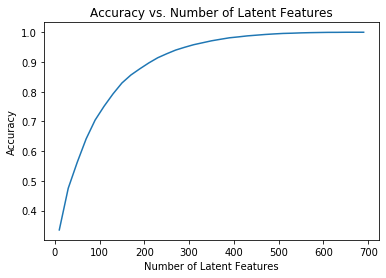

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [48]:
print(len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))
print(len(df_test.user_id.unique()) - len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))
print(len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))
print(len(df_test.article_id.unique()) - len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

20
662
574
0


In [49]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [50]:
# rewrite the above create_test_and_train_user_item function, get a user_item_test dataframe with 
# 20 rows and 714 columns

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    
    
    test_idx = np.array(user_item_test.index)
    idx_list = []
    
    for idx in np.array(user_item_test.index):
        if idx in np.array(user_item_train.index):
            idx_list.append(idx)
            
    user_item_test = user_item_test.loc[idx_list,:]
    
    rows = user_item_test.shape[0]
    
    temp = pd.DataFrame(0, index=user_item_test.index, columns=user_item_train.columns)
    for col in user_item_test.columns:
        temp[col] = user_item_test[col]
    
    user_item_test = temp
        
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)


((4487, 714), (20, 714), 20, 714)

In [51]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

# find the sub set of rows in user_item_test dataset
row = []
for idx in user_item_test.index:
    row.append(np.where(user_item_train.index == idx)[0][0])
u_train = u_train[row,:]

u_train.shape

(20, 4487)

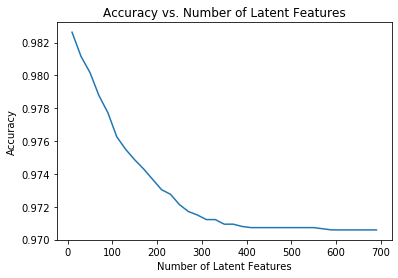

In [52]:
# plot the prediction errors

num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_test.shape[0]*user_item_test.shape[1]));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The Matrix Factorization is not do a good job. Maybe that's because:
1. The avaliable test sample size is too small
2. The stracutre of this dataframe(only has 0 and 1 values) is also not fit Matrix Factorization

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0